# Apr ??, 2022 ()

**Motivation**: Make group plots (GABAN) <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Fig dir

In [2]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(fig_dir, 'paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [4]:
mice = Mice(512)
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 7, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
    'centroids_from': 'all',
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [5]:
gr_ca = Group(**props_ca).fit_group(force=True, n_top=0, final_align=True)
gr_bo = Group(**props_bo).fit_group(force=True, n_top=0, final_align=True)
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

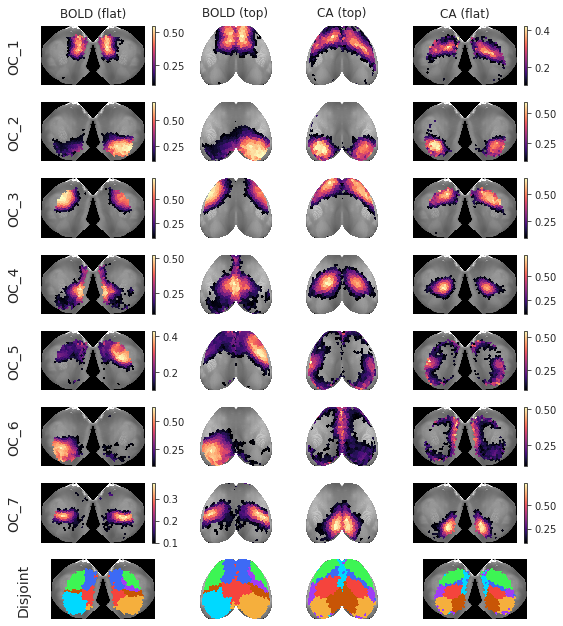

In [6]:
gr_bo.pi = gr_bo.grp_pi
gr_ca.pi = gr_ca.grp_pi

proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=False,
    min_thres=0.1,
)

In [7]:
gr_bo = Group(**props_bo).fit_group(force=True, n_top=0, final_align=False)
gr_bo = Group(**props_bo).fit_group()
gr_bo.pi = gr_bo.grp_pi
proj_bo = gr_bo.project_vec()

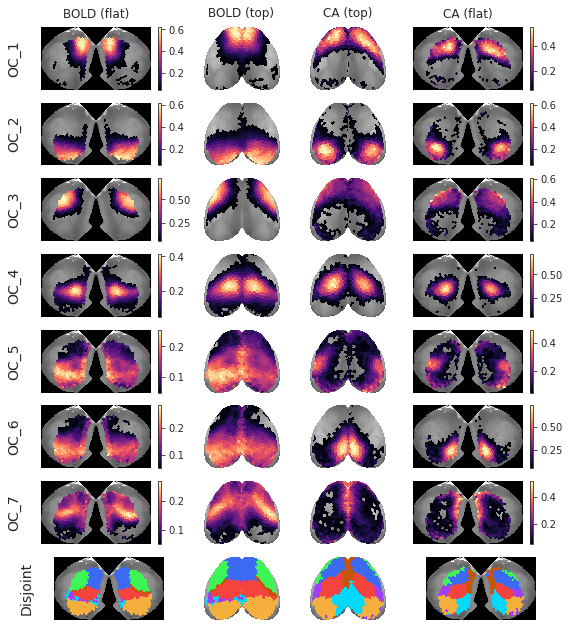

In [8]:
_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=False,
    min_thres=0.05,
)

In [31]:
def realign_data_runs(self, data: np.ndarray, fit_centroid: bool = True):
    ner = Normalizer()
    data_reord = np_nans(data.shape)
    i, j, k, num_k, num_nodes = data.shape
    if fit_centroid:
        data_good = []
        looper = itertools.product(
            range(i), range(j), range(j))
        for i, j, k in looper:
            x = data[i, j, k]
            good = np.where(np.isnan(x).sum(0) == 0)[0]
            if not len(good):
                continue
            data_good.append(x)
        data_good = np.concatenate(data_good)
        good = np.where(np.isnan(data_good).sum(0) == 0)[0]
        centroids = np.zeros((num_k, num_nodes))
        _centroids, _ = fit_kmeans(
            data=data_good[:, good],
            match_metric='euclidean',
            n_clusters=num_k,
        )
        centroids[:, good] = _centroids
        global_mapping = self.align_centroid_to_structs(
            pi_mv=centroids,
            metric=self.dist_metric,
            global_order=False,
        )
        centroids = centroids[global_mapping]
    else:
        centroids = bn.nanmean(bn.nanmean(bn.nanmean(data, 2), 1), 0)

    looper = itertools.product(
        range(i), range(j), range(j))
    for i, j, k in looper:
        x = data[i, j, k]
        good = np.where(np.isnan(x).sum(0) == 0)[0]
        if not len(good):
            continue
        perm = find_best_mappings(
            data={'x': x[:, good]},
            centroids=ner.fit_transform(centroids[:, good]),
            match_metric=self.dist_metric,
            global_order=True,
        )['x']
        data_reord[i, j, k] = x[list(perm.values())]
    return data_reord, centroids

In [41]:
x, centroids = realign_data_runs(gr_ca, gr_ca.run_centroids, fit_centroid=False)

In [42]:
_pi = centroids / np.nansum(centroids, -2, keepdims=True)
tr = gr_ca.project_vec(_pi)
tr = gr_ca.trim2d(tr)

<matplotlib.image.AxesImage object at 0x7f4860bec910>

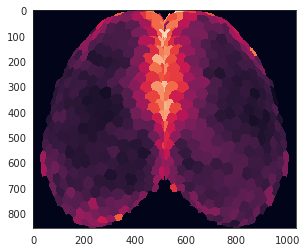

In [50]:
plt.imshow(tr['proj-top'][6])

In [51]:
gmap = gr_ca.align_centroid_to_structs(_pi, metric='cosine')
gmap

[6, 1, 2, 3, 0, 4, 5]

In [30]:
gmap = gr_ca.align_centroid_to_structs(gr_ca.pi, metric='correlation')
gmap

[6, 1, 2, 3, 0, 4, 5]

In [12]:
tr = gr_ca.project_vec(gr_ca.pi[gmap])
tr = gr_ca.trim2d(tr)

<matplotlib.image.AxesImage object at 0x7f47838f2ac0>

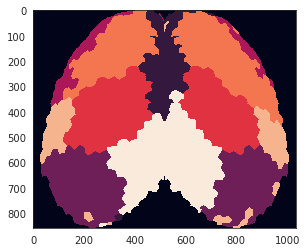

In [29]:
plt.imshow(tr['proj-top'][7])

In [10]:
x = gr_bo.realign_data_runs(gr_bo.run_centroids[..., 4:, :])
x = np.concatenate([gr_bo.run_centroids[..., :4, :], x], axis=-2)
x.shape

(10, 3, 4, 7, 542)

In [14]:
pi = x / np.nansum(x, -2, keepdims=True)
pi = bn.nanmean(bn.nanmean(bn.nanmean(pi, 2), 1), 0)
proj_new = gr_bo.project_vec(pi)

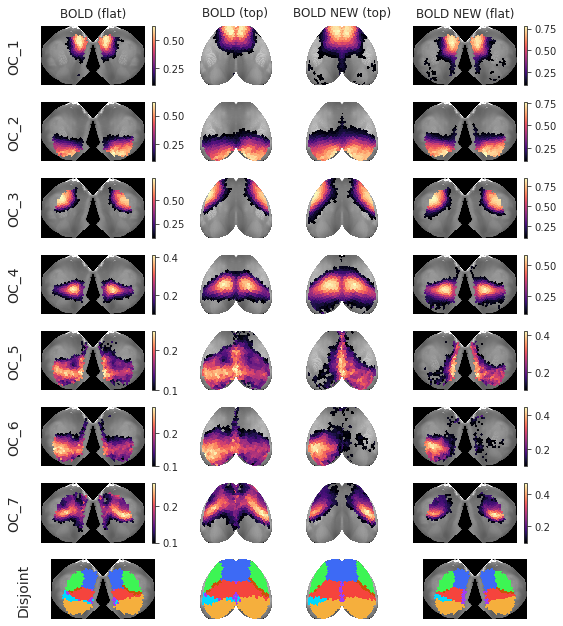

In [16]:
_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_new,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'BOLD NEW'),
    fix_cmap=False,
    min_thres=0.1,
)

------------------------------    n_top = 000    ------------------------------

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

[PROGRESS] 'se_indiv-pi_1.0e+02.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-512*3/results/SVINET/Gro
up/real_pearson_ca2_k7_p10-sample

[PROGRESS] 'se_indiv-pi_1.0e+02.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-512*3/results/SVINET/Gro
up/real_pearson_bold-lite_k7_p10-sample

BOLD (corr)   : : :   ovp: 0.9565,  disj: 0.9641

Ca2  (corr)   : : :   ovp: 0.9027,  disj: 0.9431

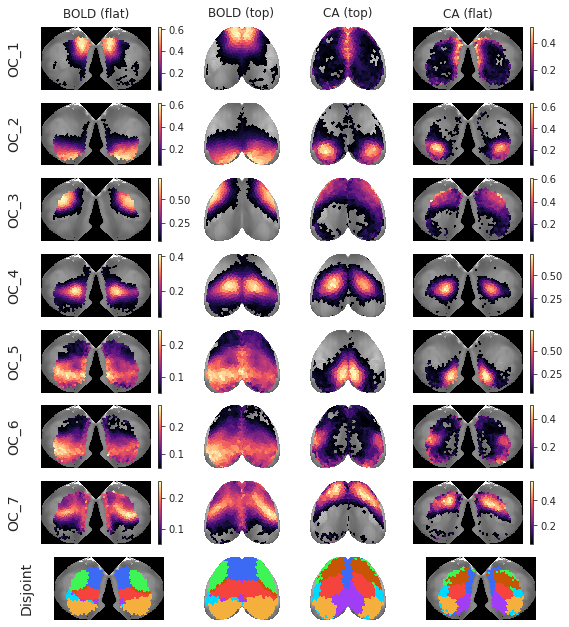

Similarity between OCs (correlation):  Avg = 0.605
OC1: 0.61, OC2: 0.71, OC3: 0.77, OC4: 0.81, OC5: 0.60, OC6: 0.28, OC7: 0.45,

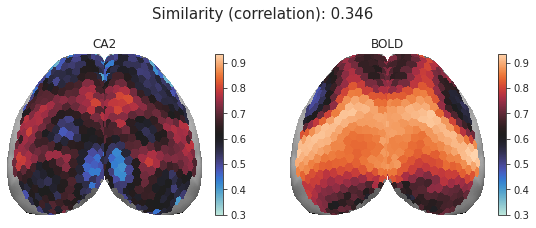

-------------------------------------------------------------------------------

------------------------------    n_top = 001    ------------------------------

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

BOLD (corr)   : : :   ovp: 0.8479,  disj: 0.8809

Ca2  (corr)   : : :   ovp: 0.9274,  disj: 0.9768

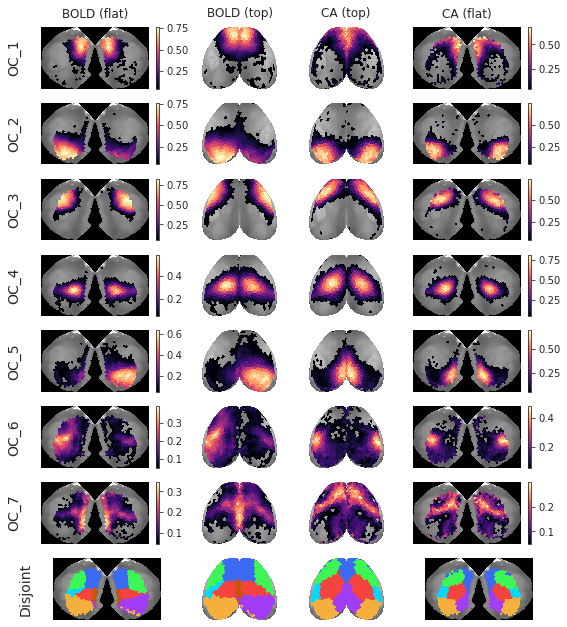

Similarity between OCs (correlation):  Avg = 0.664
OC1: 0.83, OC2: 0.75, OC3: 0.86, OC4: 0.87, OC5: 0.43, OC6: 0.56, OC7: 0.34,

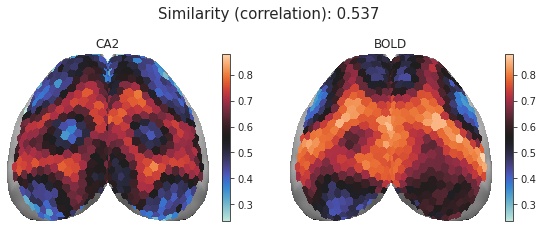

-------------------------------------------------------------------------------

------------------------------    n_top = 100    ------------------------------

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

Warning, '7' nans detected . . . filling with ones

BOLD (corr)   : : :   ovp: 0.8891,  disj: 0.8777

Ca2  (corr)   : : :   ovp: 0.9692,  disj: 0.9768

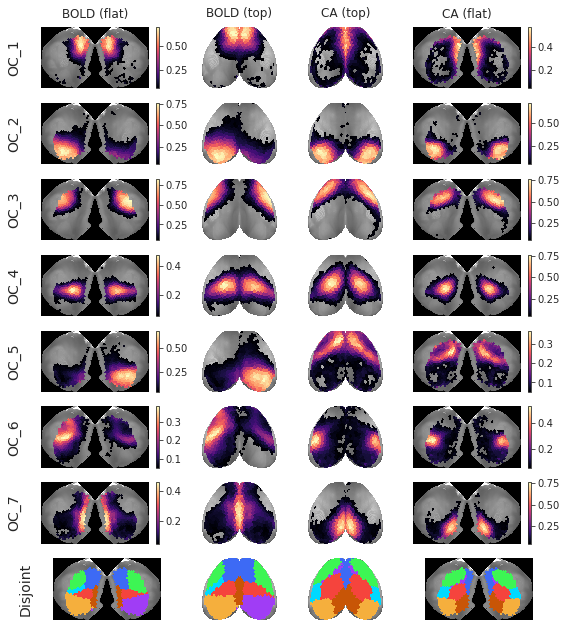

Similarity between OCs (correlation):  Avg = 0.518
OC1: 0.71, OC2: 0.73, OC3: 0.84, OC4: 0.87, OC5: -0.52, OC6: 0.54, OC7: 0.46,

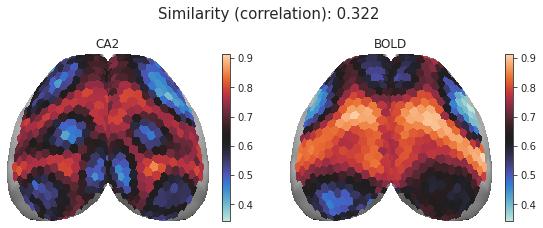

-------------------------------------------------------------------------------

CPU times: user 3h 7min 34s, sys: 6min, total: 3h 13min 34s
Wall time: 44min 4s


In [4]:
%%time

for n_top in [0, 1, 100]:
    print('-' * 30, f'   n_top = {n_top:03d}   ', '-' * 30)
    
    gr_ca = Group(**props_ca).fit_group(force=True, n_top=n_top)
    gr_bo = Group(**props_bo).fit_group(force=True, n_top=n_top)
    gr_ca = Group(**props_ca).fit_group()
    gr_bo = Group(**props_bo).fit_group()

    sim = dist2sim(sp_dist.cdist(
        XA=gr_bo.grp_pi,
        XB=gr_ca.grp_pi,
        metric='correlation',
    ))
    mapping = find_best_match(sim)
    ids = list(mapping.values())

    gr_bo.pi = gr_bo.grp_pi
    gr_ca.pi = gr_ca.grp_pi[ids]
    
    proj_bo = gr_bo.project_vec()
    proj_ca = gr_ca.project_vec()
    
    h = np.concatenate([np.expand_dims(gr_ca.grp_h, 0), np.expand_dims(gr_bo.grp_h, 0)])
    proj = gr_ca.project_vec(h, add_disjoint=False)
    tr = gr_ca.trim2d(proj)

    ovp, disj = gr_bo.pi_symmetry_score(decimals=5, metric='correlation')
    print(f"BOLD (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
    ovp, disj = gr_ca.pi_symmetry_score(decimals=5, metric='correlation')
    print(f"Ca2  (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

    _ = gr_ca.show(
        proj_1=proj_bo,
        proj_2=proj_ca,
        cmaps=('magma',) * 2,
        labels=('BOLD', 'CA'),
        fix_cmap=False,
        min_thres=0.05,
    )
    score = dist2sim(sp_dist.cdist(gr_bo.pi, gr_ca.pi, metric='correlation')).diagonal()
    msg = f'Similarity between OCs (correlation):  Avg = {score.mean():0.3f}\n'
    for i in range(num_k):
        msg += f'OC{i+1}: {score[i]:0.2f}, '
    msg += '\n'
    print(msg)
    
    vmin = np.nanmin(tr['proj-top'][tr['proj-top'].nonzero()])
    vmax = np.nanmax(tr['proj-top'][tr['proj-top'].nonzero()])
    kwargs = {'cmap': 'icefire', 'vmin': vmin, 'vmax': vmax}

    fig, axes = create_figure(1, 2, (8, 3))
    for ax in axes.flat:
        ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
    im = axes[0].imshow(mwh(tr['proj-top'][0] == 0, tr['proj-top'][0]), **kwargs)
    plt.colorbar(im, ax=axes[0])
    axes[0].set_title('CA2')
    im = axes[1].imshow(mwh(tr['proj-top'][1] == 0, tr['proj-top'][1]), **kwargs)
    plt.colorbar(im, ax=axes[1])
    axes[1].set_title('BOLD')
    sim_h = sp_stats.pearsonr(gr_ca.grp_h, gr_bo.grp_h)[0]
    fig.suptitle(f'Similarity (correlation): {sim_h:0.3f}', y=1.04, fontsize=15)
    remove_ticks(axes)
    plt.show()
    
    print('-' * 79)
    print('\n\n')

In [8]:
num_k = 5
props_ca['num_k'] = num_k
props_bo['num_k'] = num_k

------------------------------    n_top = 000    ------------------------------

BOLD (corr)   : : :   ovp: 0.9724,  disj: 0.9528

Ca2  (corr)   : : :   ovp: 0.9722,  disj: 0.9528

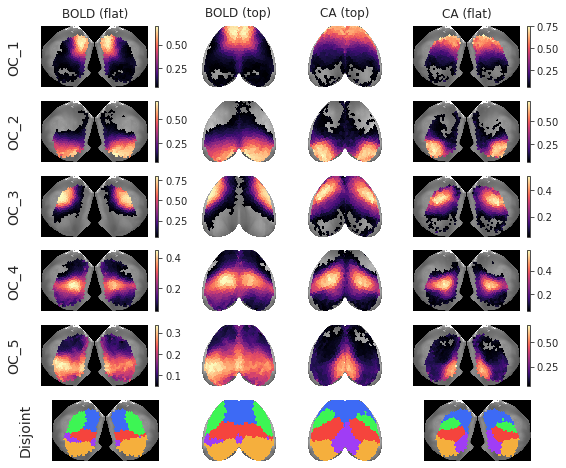

Similarity between OCs (correlation):  Avg = 0.784
OC1: 0.76, OC2: 0.87, OC3: 0.85, OC4: 0.88, OC5: 0.56,

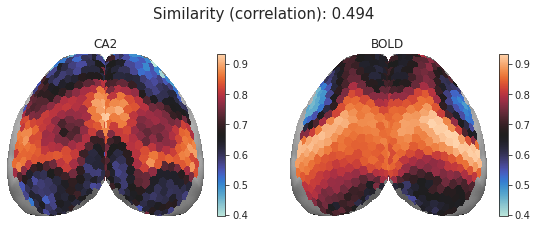

-------------------------------------------------------------------------------

------------------------------    n_top = 001    ------------------------------

BOLD (corr)   : : :   ovp: 0.8946,  disj: 0.8760

Ca2  (corr)   : : :   ovp: 0.9453,  disj: 0.9616

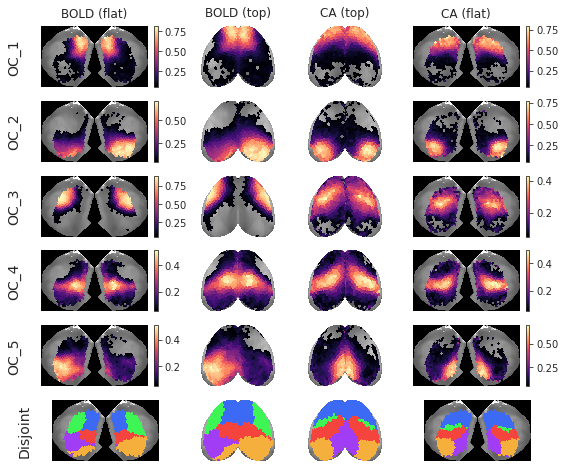

Similarity between OCs (correlation):  Avg = 0.624
OC1: 0.63, OC2: 0.77, OC3: 0.60, OC4: 0.72, OC5: 0.41,

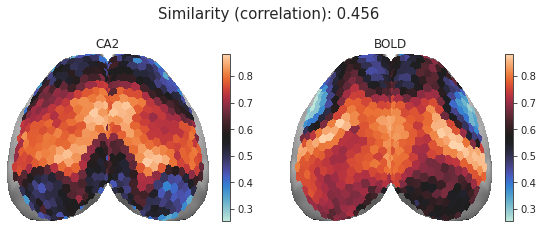

-------------------------------------------------------------------------------

------------------------------    n_top = 100    ------------------------------

BOLD (corr)   : : :   ovp: 0.9035,  disj: 0.8391

Ca2  (corr)   : : :   ovp: 0.9730,  disj: 0.9601

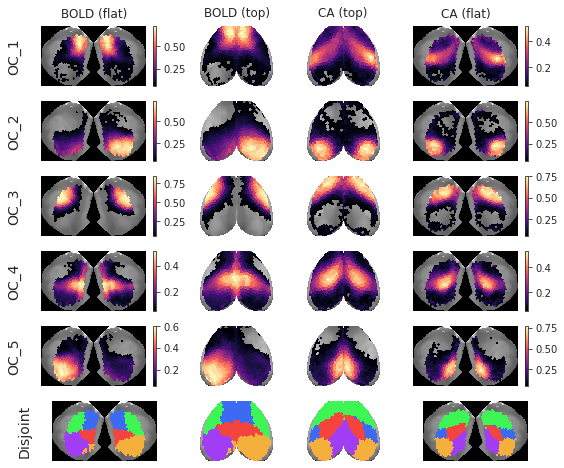

Similarity between OCs (correlation):  Avg = 0.493
OC1: 0.22, OC2: 0.66, OC3: 0.69, OC4: 0.58, OC5: 0.32,

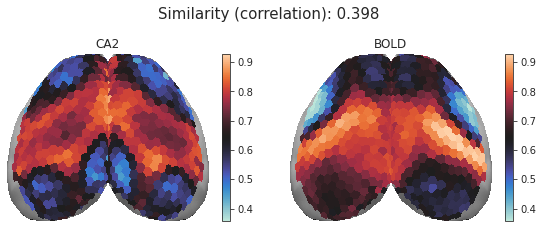

-------------------------------------------------------------------------------

CPU times: user 2h 15min 30s, sys: 3min 30s, total: 2h 19min
Wall time: 38min 15s


In [9]:
%%time

for n_top in [0, 1, 100]:
    print('-' * 30, f'   n_top = {n_top:03d}   ', '-' * 30)
    
    gr_ca = Group(**props_ca).fit_group(force=True, n_top=n_top)
    gr_bo = Group(**props_bo).fit_group(force=True, n_top=n_top)
    gr_ca = Group(**props_ca).fit_group()
    gr_bo = Group(**props_bo).fit_group()

    sim = dist2sim(sp_dist.cdist(
        XA=gr_bo.grp_pi,
        XB=gr_ca.grp_pi,
        metric='correlation',
    ))
    mapping = find_best_match(sim)
    ids = list(mapping.values())

    gr_bo.pi = gr_bo.grp_pi
    gr_ca.pi = gr_ca.grp_pi[ids]
    
    proj_bo = gr_bo.project_vec()
    proj_ca = gr_ca.project_vec()
    
    h = np.concatenate([np.expand_dims(gr_ca.grp_h, 0), np.expand_dims(gr_bo.grp_h, 0)])
    proj = gr_ca.project_vec(h, add_disjoint=False)
    tr = gr_ca.trim2d(proj)

    ovp, disj = gr_bo.pi_symmetry_score(decimals=5, metric='correlation')
    print(f"BOLD (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
    ovp, disj = gr_ca.pi_symmetry_score(decimals=5, metric='correlation')
    print(f"Ca2  (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

    _ = gr_ca.show(
        proj_1=proj_bo,
        proj_2=proj_ca,
        cmaps=('magma',) * 2,
        labels=('BOLD', 'CA'),
        fix_cmap=False,
        min_thres=0.05,
    )
    score = dist2sim(sp_dist.cdist(gr_bo.pi, gr_ca.pi, metric='correlation')).diagonal()
    msg = f'Similarity between OCs (correlation):  Avg = {score.mean():0.3f}\n'
    for i in range(num_k):
        msg += f'OC{i+1}: {score[i]:0.2f}, '
    msg += '\n'
    print(msg)
    
    vmin = np.nanmin(tr['proj-top'][tr['proj-top'].nonzero()])
    vmax = np.nanmax(tr['proj-top'][tr['proj-top'].nonzero()])
    kwargs = {'cmap': 'icefire', 'vmin': vmin, 'vmax': vmax}

    fig, axes = create_figure(1, 2, (8, 3))
    for ax in axes.flat:
        ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
    im = axes[0].imshow(mwh(tr['proj-top'][0] == 0, tr['proj-top'][0]), **kwargs)
    plt.colorbar(im, ax=axes[0])
    axes[0].set_title('CA2')
    im = axes[1].imshow(mwh(tr['proj-top'][1] == 0, tr['proj-top'][1]), **kwargs)
    plt.colorbar(im, ax=axes[1])
    axes[1].set_title('BOLD')
    sim_h = sp_stats.pearsonr(gr_ca.grp_h, gr_bo.grp_h)[0]
    fig.suptitle(f'Similarity (correlation): {sim_h:0.3f}', y=1.04, fontsize=15)
    remove_ticks(axes)
    plt.show()
    
    print('-' * 79)
    print('\n\n')

In [5]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

# ids_bo = [0, 1, 2, 3, 8, 6, 7, 5, 4]
ids_bo = range(num_k)

sim = dist2sim(sp_dist.cdist(
    XA=gr_bo.grp_pi[ids_bo],
    XB=gr_ca.grp_pi,
    metric='correlation',
))
mapping = find_best_match(sim)
ids_ca = list(mapping.values())

gr_bo.pi = gr_bo.grp_pi[ids_bo]
gr_ca.pi = gr_ca.grp_pi[ids_ca]

ids_ca

[0, 1, 2, 3, 10, 5, 7, 11, 6, 8, 4, 9, 12]

BOLD   : : :   ovp: 0.9810,  disj: 0.9637

Ca2    : : :   ovp: 0.9616,  disj: 0.9620

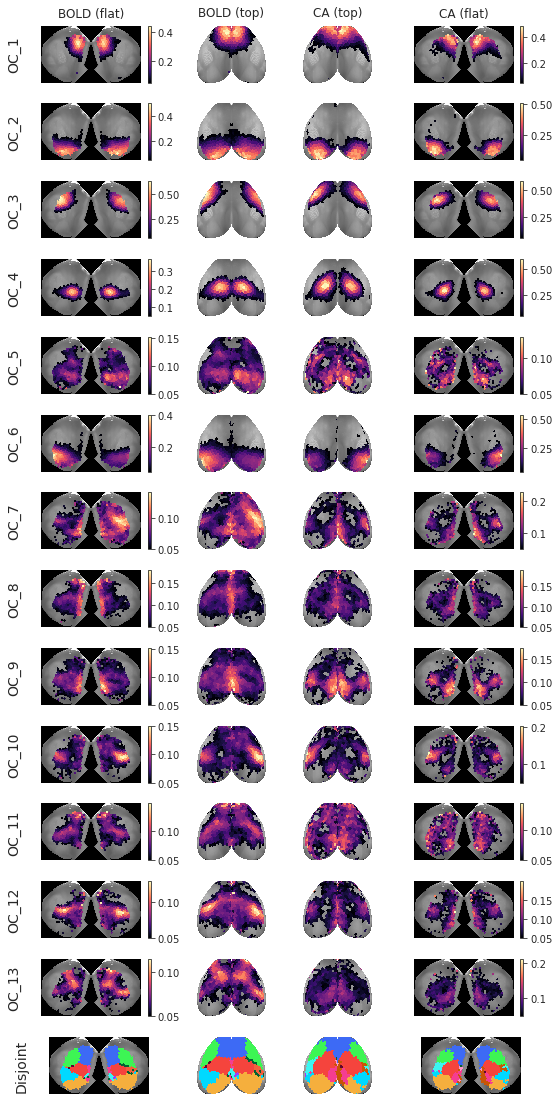

In [8]:
proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

ovp, disj = gr_bo.pi_symmetry_score(decimals=5)
print(f"BOLD   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
ovp, disj = gr_ca.pi_symmetry_score(decimals=5)
print(f"Ca2    : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=False,
    min_thres=0.05,
)

Similarity between OCs (correlation):  Avg = 0.587
OC1: 0.88, OC2: 0.90, OC3: 0.92, OC4: 0.88, OC5: 0.24, OC6: 0.73, OC7: 0.47, OC8: 0.63, OC9: 
0.66, OC10: 0.50, OC11: 0.32, OC12: 0.50, OC13: 0.00,

0.6507115555755686

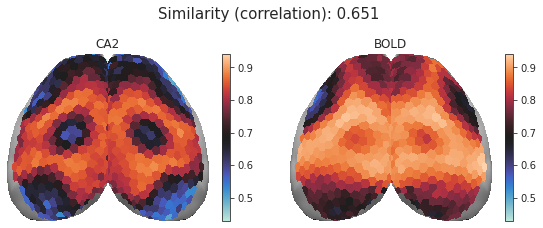

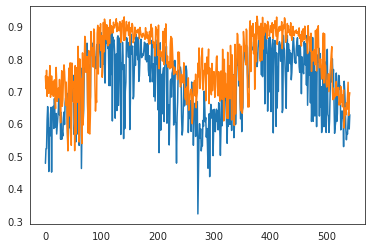

In [11]:
h = np.concatenate([np.expand_dims(gr_ca.grp_h, 0), np.expand_dims(gr_bo.grp_h, 0)])
plt.plot(h[0])
plt.plot(h[1]);

In [12]:
proj = gr_ca.project_vec(h, add_disjoint=False)
tr = gr_ca.trim2d(proj)

In [13]:
vmin = np.nanmin(tr['proj-top'][tr['proj-top'].nonzero()])
vmax = np.nanmax(tr['proj-top'][tr['proj-top'].nonzero()])
vmin, vmax

(0.4365780967919868, 0.9308912918930862)

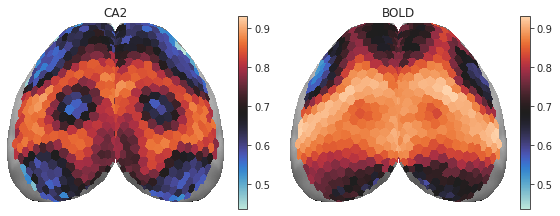

In [14]:
cmap = 'icefire'

fig, axes = create_figure(1, 2, (8, 3))
for ax in axes.flat:
    ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
im = axes[0].imshow(mwh(tr['proj-top'][0] == 0, tr['proj-top'][0]), cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axes[0])
axes[0].set_title('CA2')
im = axes[1].imshow(mwh(tr['proj-top'][1] == 0, tr['proj-top'][1]), cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axes[1])
axes[1].set_title('BOLD')

remove_ticks(axes)
plt.show()

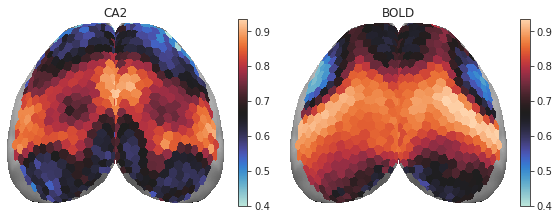

In [15]:
np.nanmax(gr_bo.run_h)

1.5612682484721854

In [11]:
np.where(gr_bold.run_h == np.nanmax(gr_bold.run_h))

(array([2]), array([1]), array([0]), array([277]))

In [13]:
gr_bold.run_h[2, 1, 0]

memmap([0.74743282, 0.79664377, 0.62397725, 0.70527257,        nan,
               nan, 0.23699731, 0.2974088 , 0.57091734, 0.70644864,
               nan, 0.20692194, 0.42243413, 0.55103453, 0.70994795,
        0.71449347, 0.42626893, 0.26783829, 0.34902437, 0.45568746,
        0.19391142, 0.17713098, 0.75116433, 0.25595751, 0.82282736,
        0.53671805, 0.5672274 , 0.16992294, 0.46665781, 0.17273196,
        0.16897404, 0.31191606, 0.27536076, 0.63494517, 0.54374759,
        0.85963615, 0.87706153, 0.62416956, 0.86006199, 0.44108569,
        0.62495984, 0.24846781, 0.49851149, 0.23201515, 0.70996482,
        0.97561064, 0.72633813, 0.62604653, 0.93342545, 0.69570195,
               nan, 0.22597198, 0.78721167, 0.53535073, 0.6718904 ,
        0.23418266, 0.43289595, 0.55598077, 0.83881626, 0.74663473,
        0.70341654, 0.64952368, 0.93542354, 0.64820974, 0.559994  ,
        0.59040208, 0.60811558, 0.62722973, 0.56441732, 0.15580433,
        0.70240033, 0.93480795, 0.74939545, 0.31870621, 0.68561562,
        0.64203284, 0.64467542, 0.28681989, 0.69916294, 0.76088535,
        0.56531476, 0.86099074, 0.79712377, 0.34046542, 0.9546821 ,
        0.61530131,        nan, 0.60299168, 0.56696942, 0.77074172,
        0.69291831, 0.78649045, 0.79905115, 0.67130775, 0.60867989,
        0.82304317, 0.24838222, 0.96012867, 0.81013953, 0.615732  ,
        0.68937702, 0.90899942, 0.81141832, 0.8940266 , 0.73129066,
        0.85034286, 0.64176208, 0.30322341, 0.75408253, 0.84713658,
        0.19524141, 0.94477528, 0.79184021, 0.81427993, 0.7976667 ,
        0.76743483, 0.73065405, 0.80523423, 0.90613157, 0.70662432,
        0.75603138, 0.9373631 , 0.81333064, 0.89691723, 0.65814154,
        0.89708083, 0.95403463, 0.71737244, 0.74177874, 0.27602805,
        0.9075056 , 0.82791151, 0.92518269, 0.9030753 , 0.73400534,
        0.93991   , 0.51558483, 0.62452944, 0.19503503, 0.87583484,
        1.06024148, 0.82842121, 0.91591583, 0.87169645, 0.77369179,
        0.48718268, 0.85803057, 0.8505139 , 0.56589036, 0.99643172,
        0.89282711, 0.89246315, 0.89758491, 0.33154545, 1.05675426,
        1.08118283, 0.99245233, 0.90814027, 0.98407486, 0.91786225,
        0.86598423, 0.81059776, 0.71000863, 0.80011385, 0.63201152,
        1.04233882, 0.87500521, 0.90345966, 0.74625269, 0.94163053,
        0.86885039, 1.019591  , 1.05929636, 1.02815006, 0.8002605 ,
        0.99186852, 0.7002721 , 0.73816947, 0.7864236 , 0.83124592,
        0.61272052, 0.94675083, 0.90826991, 0.95841957, 0.88126966,
        0.87263198, 0.78753655, 1.04727579, 0.8838479 , 0.8824158 ,
        0.81379809, 0.85329454, 0.83829883, 0.95566807, 0.6608287 ,
        0.8209685 , 0.99323459, 1.04112672, 0.88093058, 0.93030729,
        0.99131324, 0.88513905, 0.61958855, 0.88009534, 0.77843418,
        0.94176422, 0.8727822 , 0.86286226, 0.96736652, 0.82088955,
        1.05097529, 0.85086458, 0.72205289, 0.59199778, 0.98014131,
        0.58314511, 0.93828624, 0.8124526 , 0.74072459, 0.79125012,
        0.9110369 , 0.85578407, 0.97376363, 0.99331564, 0.88683353,
               nan, 0.40397772, 0.24468134, 0.69688297, 0.49699742,
        0.3408188 , 0.68902514, 0.6808022 , 0.6676212 , 0.53871509,
        0.60293599,        nan, 1.00051821, 0.79233359, 0.12469597,
        0.42843856, 0.12505294, 0.56937592, 0.48095787, 0.54123614,
        0.55271876, 1.023472  , 0.61380913, 0.34687462,        nan,
        0.34655096, 0.56767208, 0.22129659,        nan, 0.60253551,
        0.42700818, 0.88757584, 0.47208112, 0.29015673, 0.70315865,
               nan, 0.71585274, 0.35639876, 0.58838178, 0.94393902,
        0.45258308, 0.76140625, 0.80937022, 0.81282127, 0.90579485,
        0.78598342, 0.54855111,        nan,        nan,        nan,
        0.99362917, 0.77975386, 1.15656375, 1.15575086, 1.1292042 ,
               nan, 0.93023883, 0.24936765, 0.70964167, 0.67773122,
               nan, 0.73227868, 1.0350934 , 1.05591357, 0.9746205 ,
        0.69434116, 0.21727318, 0.36193068, 0.96024103, 

In [14]:
a = gr_bold.run_pi[2, 1, 0]
a.shape

(5, 542)

In [17]:
a[:, 276:278]

array([[0.49391082, 0.20318705],
       [0.05270044, 0.17093371],
       [0.38310772, 0.23022644],
       [0.06305601, 0.21588913],
       [0.00722501, 0.17976367]])

In [18]:
b = sp_stats.entropy(gr_bold.run_pi[2, 1, 0], axis=0) / np.log(5)

<AxesSubplot:ylabel='Count'>

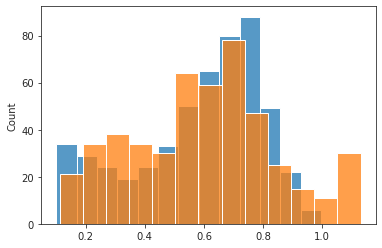

In [19]:
sns.histplot(b)
sns.histplot(gr_bold.run_h[8, 2, 1], color='C1')